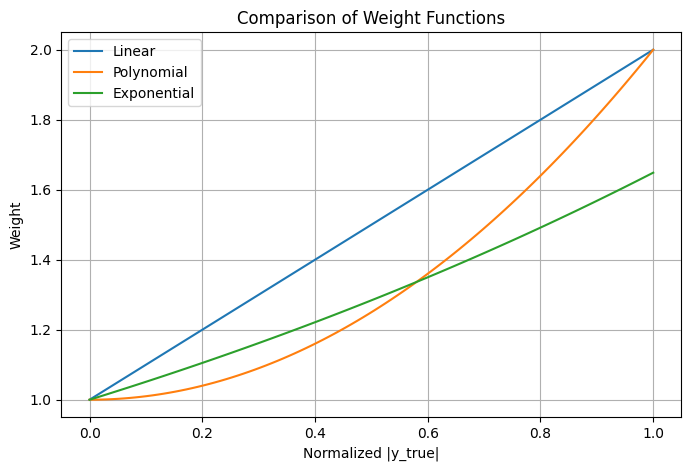

Training MSE model for Horizon 1
Horizon 1: RMSE (All) = 328.0356, RMSE (Extreme) = 696.9563
Training MSE model for Horizon 2


KeyboardInterrupt: 

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

##########################################
# Data Loading and Preprocessing
##########################################

def low_pass(series, a1):
    return series.ewm(alpha=1 - a1, adjust=False).mean()

D = pd.read_csv("/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv")
D['t'] = pd.to_datetime(D['time'])
D['y'] = D['KarupBro']
D_time_indexed = D.set_index('t').sort_index()

D_time_indexed.loc[D_time_indexed['temp_mean_daily'] > 35, 'temp_mean_daily'] = D_time_indexed['temp_mean_daily'].shift(1)
D_time_indexed.loc[D_time_indexed['precip_total_daily'] > 100, 'precip_total_daily'] = 0

D_time_indexed['temp_forecast'] = D_time_indexed['temp_mean_daily']
D_time_indexed['precip_forecast'] = low_pass(D_time_indexed['precip_total_daily'], a1=0.9)
D_time_indexed['Year_sin'] = np.sin(2 * np.pi * D_time_indexed.index.dayofyear / 365)
D_time_indexed['Year_cos'] = np.cos(2 * np.pi * D_time_indexed.index.dayofyear / 365)

score_period = D_time_indexed.index[-1023:]
score_start = score_period[0]

##########################################
# Helper Functions
##########################################

def create_offline_dataset_horizon(df, window_size, k, a1=0.9):
    X_hist_list, X_forecast_list, y_list, indices = [], [], [], []
    for i in range(window_size, len(df) - (k - 1)):
        target_date = df.index[i + (k - 1)]
        hist = df.iloc[i - window_size:i][['y', 'temp_mean_daily', 'precip_total_daily']].values.astype(np.float32)
        fcst = np.array([
            df.iloc[i + (k - 1)]['temp_forecast'],
            df.iloc[i + (k - 1)]['precip_forecast'],
            np.sin(2 * np.pi * target_date.dayofyear / 365),
            np.cos(2 * np.pi * target_date.dayofyear / 365)
        ], dtype=np.float32)
        label = float(df.iloc[i + (k - 1)]['y'])
        X_hist_list.append(hist)
        X_forecast_list.append(fcst)
        y_list.append(label)
        indices.append(target_date)
    return np.array(X_hist_list), np.array(X_forecast_list), np.array(y_list), np.array(indices)

def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Weighted MSE Loss Functions (Symmetric)
def weighted_mse_linear(y_true, y_pred):
    error = tf.square(y_true - y_pred)
    weights = 1.0 + (tf.abs(y_true) / tf.reduce_max(tf.abs(y_true)))
    return tf.reduce_mean(weights * error)

def weighted_mse_polynomial(y_true, y_pred):
    error = tf.square(y_true - y_pred)
    weights = 1.0 + (tf.abs(y_true) / tf.reduce_max(tf.abs(y_true)))**2
    return tf.reduce_mean(weights * error)

def weighted_mse_exponential(y_true, y_pred):
    error = tf.square(y_true - y_pred)
    weights = tf.exp(0.5 * (tf.abs(y_true) / tf.reduce_max(tf.abs(y_true))))
    return tf.reduce_mean(weights * error)

def build_offline_model(window_size, loss_fn):
    hist_input = Input(shape=(window_size, 3))
    x = LSTM(64, activation='relu')(hist_input)
    x = Dense(64, activation='relu')(x)
    fcst_input = Input(shape=(4,))
    y = Dense(32, activation='relu')(fcst_input)
    y = Dense(32, activation='relu')(y)
    combined = Concatenate()([x, y])
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)
    model = Model(inputs=[hist_input, fcst_input], outputs=output)
    model.compile(optimizer=Adam(0.001), loss=loss_fn)
    return model

def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.nanmean((y_true - y_pred)**2))

def calculate_rmse_extreme(y_true, y_pred, percentile=90):
    threshold = np.percentile(y_true, percentile)
    mask = y_true >= threshold
    return np.sqrt(np.nanmean((y_true[mask] - y_pred[mask])**2))

##########################################
# Weight Function Visualization
##########################################

x_vals = np.linspace(0, 1, 100)
plt.figure(figsize=(8,5))
plt.plot(x_vals, 1 + x_vals, label='Linear')
plt.plot(x_vals, 1 + x_vals**2, label='Polynomial')
plt.plot(x_vals, np.exp(0.5 * x_vals), label='Exponential')
plt.title("Comparison of Weight Functions")
plt.xlabel("Normalized |y_true|")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.show()

##########################################
# Training and Evaluation
##########################################

window_size = 10
horizons = [1, 2, 3, 4, 5]
loss_types = ['mse', 'linear', 'polynomial', 'exponential']

loss_functions = {
    'mse': mse_loss,
    'linear': weighted_mse_linear,
    'polynomial': weighted_mse_polynomial,
    'exponential': weighted_mse_exponential,
}

results = {}

for loss_type in loss_types:
    rmse_all = {}
    rmse_extreme = {}
    forecasts = {}

    for k in horizons:
        print(f"Training {loss_type.upper()} model for Horizon {k}")
        
        X_hist, X_fcst, y, indices = create_offline_dataset_horizon(D_time_indexed, window_size, k)
        train_mask = indices < score_start
        test_mask = indices >= score_start

        X_hist_train, X_fcst_train, y_train = X_hist[train_mask], X_fcst[train_mask], y[train_mask]
        X_hist_test, X_fcst_test, y_test, indices_test = X_hist[test_mask], X_fcst[test_mask], y[test_mask], indices[test_mask]

        if len(y_test) == 0:
            continue

        model = build_offline_model(window_size, loss_fn=loss_functions[loss_type])

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ]

        model.fit([X_hist_train, X_fcst_train], y_train,
                  validation_split=0.2,
                  epochs=100,
                  batch_size=32,
                  verbose=0,
                  callbacks=callbacks)

        y_pred = model.predict([X_hist_test, X_fcst_test], verbose=0).flatten()
        
        forecasts[k] = (indices_test, y_test, y_pred)
        rmse_all[k] = calculate_rmse(y_test, y_pred)
        rmse_extreme[k] = calculate_rmse_extreme(y_test, y_pred)

        print(f"Horizon {k}: RMSE (All) = {rmse_all[k]:.4f}, RMSE (Extreme) = {rmse_extreme[k]:.4f}")

    results[loss_type] = {'forecasts': forecasts, 'rmse_all': rmse_all, 'rmse_extreme': rmse_extreme}

##########################################
# Plotting
##########################################

for loss_type in loss_types:
    idx, y_true, y_pred = results[loss_type]['forecasts'][1]
    plt.figure(figsize=(12,6))
    plt.plot(idx, y_true, label='Actual')
    plt.plot(idx, y_pred, label=f'{loss_type.upper()} Forecast', linestyle='--')
    plt.title(f'Actual vs Forecasted y (Horizon 1) - {loss_type.upper()}')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()

plt.figure(figsize=(8,5))
for loss_type in loss_types:
    rmse_values = [results[loss_type]['rmse_all'][k] for k in horizons]
    plt.plot(horizons, rmse_values, marker='o', label=f'{loss_type.upper()} Forecast')
plt.xlabel('Forecast Horizon (k)')
plt.ylabel('RMSE (All data)')
plt.title('RMSE vs Horizon (All data)')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
for loss_type in loss_types:
    rmse_values_extreme = [results[loss_type]['rmse_extreme'][k] for k in horizons]
    plt.plot(horizons, rmse_values_extreme, marker='x', label=f'{loss_type.upper()} Forecast (extreme)')
plt.xlabel('Forecast Horizon (k)')
plt.ylabel('RMSE (Top 10% extreme)')
plt.title('RMSE vs Horizon (Top 10% extreme values)')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ensure TensorFlow is installed: pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------------------
# 1) Data loading & preprocessing
# ----------------------------------------
data_path = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
D = pd.read_csv(data_path)

# parse datetime & set index
D['t'] = pd.to_datetime(D['time'])
D = D.set_index('t').sort_index()

# target variable
D['y'] = D['KarupBro']

# clean outliers
D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = 0

# prepare forecast features
def low_pass(series, a1=0.9):
    return series.ewm(alpha=1 - a1, adjust=False).mean()

D['temp_forecast']   = D['temp_mean_daily']
D['precip_forecast'] = low_pass(D['precip_total_daily'], a1=0.9)
D['Year_sin'] = np.sin(2 * np.pi * D.index.dayofyear / 365)
D['Year_cos'] = np.cos(2 * np.pi * D.index.dayofyear / 365)

# define test split
score_period = D.index[-1023:]
score_start  = score_period[0]

# ----------------------------------------
# 2) Dataset creation functions
# ----------------------------------------
def create_offline_dataset(df, window_size, k, hist_cols, fcst_cols):
    Xh, Xf, y, idxs = [], [], [], []
    n = len(df)
    for i in range(window_size, n - (k - 1)):
        target_idx = i + (k - 1)
        # history window
        hist = df[hist_cols].iloc[i-window_size:i].values.astype(np.float32)
        # forecast‐day features
        row = df.iloc[target_idx]
        fcst = row[fcst_cols].values.astype(np.float32)
        Xh.append(hist)
        Xf.append(fcst)
        y.append(float(row['y']))
        idxs.append(df.index[target_idx])
    return np.stack(Xh), np.stack(Xf), np.array(y), np.array(idxs)

# ----------------------------------------
# 3) Model builder
# ----------------------------------------
def build_model(window_size, n_hist, n_fcst):
    hist_input = Input(shape=(window_size, n_hist))
    x = LSTM(64, activation='relu')(hist_input)
    x = Dense(64, activation='relu')(x)
    fcst_input = Input(shape=(n_fcst,))
    y_branch = Dense(32, activation='relu')(fcst_input)
    y_branch = Dense(32, activation='relu')(y_branch)
    combined = Concatenate()([x, y_branch])
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)
    model = Model([hist_input, fcst_input], output)
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

# ----------------------------------------
# 4) Forward‐selection over all numeric vars
# ----------------------------------------
def forward_selection_lstm_all(df, window_size, k, score_start):
    # baseline features: include lagged inflow, precip + sin/cos from start
    base_hist = ['y', 'precip_total_daily', 'Year_sin', 'Year_cos']
    base_fcst = ['precip_forecast', 'Year_sin', 'Year_cos']
    # all numeric except baseline, target 'y' and raw 'KarupBro'
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    exclude = set(base_hist + base_fcst + ['y', 'KarupBro'])
    candidates = [c for c in numeric if c not in exclude]
    
    selected = []
    best_rmse = np.inf

    while candidates:
        trials = []
        for f in candidates:
            hist_cols = base_hist + selected + [f]
            fcst_cols = base_fcst + selected + [f]
            # create data
            Xh, Xf, y_arr, idxs = create_offline_dataset(df, window_size, k, hist_cols, fcst_cols)
            # split by time
            mask = idxs >= score_start
            Xh_train, Xh_test = Xh[~mask], Xh[mask]
            Xf_train, Xf_test = Xf[~mask], Xf[mask]
            y_train, y_test   = y_arr[~mask], y_arr[mask]
            if len(y_test) == 0:
                continue
            # train
            model = build_model(window_size, len(hist_cols), len(fcst_cols))
            es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            model.fit([Xh_train, Xf_train], y_train,
                      validation_split=0.2, epochs=50, batch_size=32,
                      verbose=0, callbacks=[es])
            # Evaluate RMSE
            y_pred = model.predict([Xh_test, Xf_test], verbose=0).flatten()
            rmse = np.sqrt(np.nanmean((y_test - y_pred)**2))
            trials.append((rmse, f))
        if not trials:
            break
        trials.sort(key=lambda x: x[0])
        rmse_cand, feat_cand = trials[0]
        if rmse_cand < best_rmse:
            selected.append(feat_cand)
            best_rmse = rmse_cand
            candidates.remove(feat_cand)
            print(f"Added '{feat_cand}', RMSE = {best_rmse:.4f}")
        else:
            break

    return selected, best_rmse

# ----------------------------------------
# 5) Run selection
# ----------------------------------------
window_size = 10
k = 1  # one‐day ahead
selected_features, final_rmse = forward_selection_lstm_all(
    D, window_size, k, score_start
)

print("\nFinal selected features:", selected_features)
print(f"Final RMSE on test period: {final_rmse:.4f}")

Added 'temp_min_daily', RMSE = 310.5713
Added 'wind_speed_daily', RMSE = 305.3990
Added 'precip_duration_daily', RMSE = 304.6495

Final selected features: ['temp_min_daily', 'wind_speed_daily', 'precip_duration_daily']
Final RMSE on test period: 304.6495


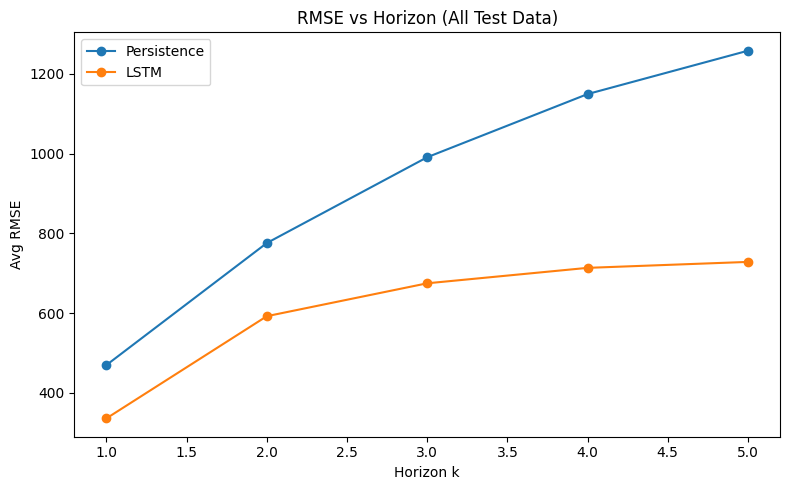

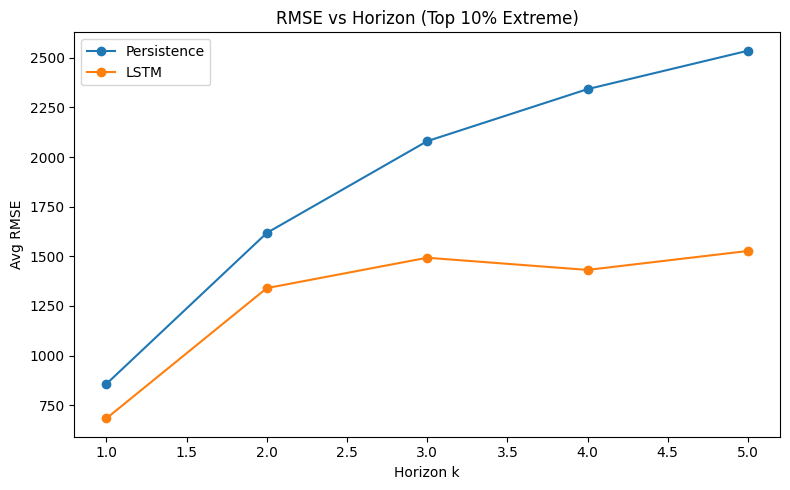

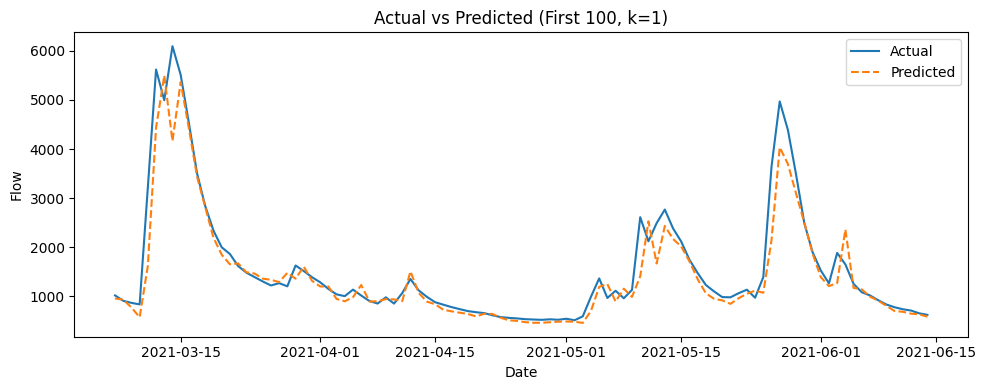

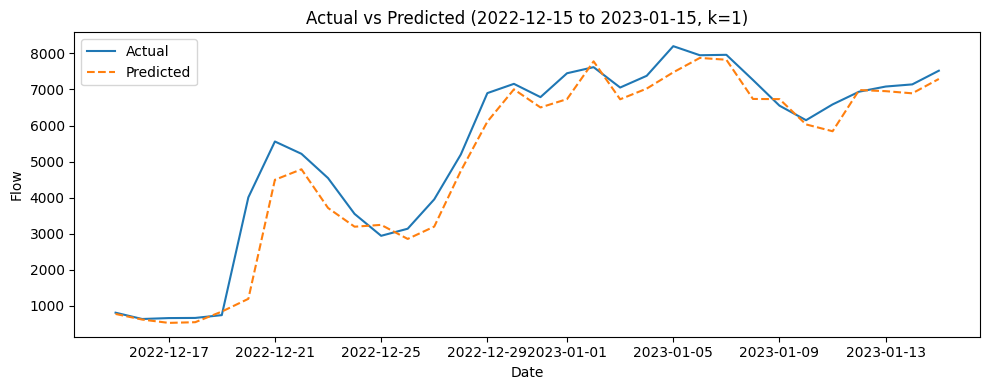

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ensure TensorFlow is installed: pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ----------------------------------------
# 1) Data loading & preprocessing
# ----------------------------------------
data_path = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated_ET0.csv"
D = pd.read_csv(data_path)

# parse datetime & set index
D['t'] = pd.to_datetime(D['time'])
D = D.set_index('t').sort_index()

# target variable
D['y'] = D['KarupBro']

# clean outliers
D.loc[D['temp_mean_daily'] > 35, 'temp_mean_daily'] = np.nan
D.loc[D['precip_total_daily'] > 100, 'precip_total_daily'] = 0

# low-pass filter for forecast features
def low_pass(series, a1=0.9):
    return series.ewm(alpha=1 - a1, adjust=False).mean()

# prepare forecast features
D['temp_forecast']   = D['temp_mean_daily']
D['precip_forecast'] = low_pass(D['precip_total_daily'], a1=0.9)
D['Year_sin'] = np.sin(2 * np.pi * D.index.dayofyear / 365)
D['Year_cos'] = np.cos(2 * np.pi * D.index.dayofyear / 365)

# define test split
score_period = D.index[-1023:]
score_start  = score_period[0]

# ----------------------------------------
# 2) Dataset and model definitions
# ----------------------------------------
def create_offline_dataset(df, window_size, k, hist_cols, fcst_cols):
    Xh, Xf, y, idxs = [], [], [], []
    n = len(df)
    for i in range(window_size, n - (k - 1)):
        idx = i + (k - 1)
        hist = df[hist_cols].iloc[i-window_size:i].values.astype(np.float32)
        fcst = df[fcst_cols].iloc[idx].values.astype(np.float32)
        Xh.append(hist); Xf.append(fcst)
        y.append(float(df['y'].iloc[idx])); idxs.append(df.index[idx])
    return np.stack(Xh), np.stack(Xf), np.array(y), np.array(idxs)

def build_model(window_size, n_hist, n_fcst):
    hist_input = Input(shape=(window_size, n_hist))
    x = LSTM(64, activation='relu')(hist_input)
    x = Dense(64, activation='relu')(x)
    fcst_input = Input(shape=(n_fcst,))
    yb = Dense(32, activation='relu')(fcst_input)
    yb = Dense(32, activation='relu')(yb)
    combined = Concatenate()([x, yb])
    combined = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='linear')(combined)
    m = Model([hist_input, fcst_input], output)
    m.compile(optimizer=Adam(0.001), loss='mse')
    return m

# ----------------------------------------
# 3) Setup horizons, runs & features
# ----------------------------------------
window_size = 10
horizons = [1,2,3,4,5]
runs = 5

base_hist = ['y','precip_total_daily','Year_sin','Year_cos']
base_fcst = ['precip_forecast','Year_sin','Year_cos']
selected_features = ['temp_min_daily', 'wind_speed_daily', 'precip_duration_daily']  # your optimal subset

hist_cols = base_hist + selected_features
fcst_cols = base_fcst + selected_features

# ----------------------------------------
# 4) Compute persistence RMSE once
# ----------------------------------------
pers_all = {}
pers_ext = {}
for k in horizons:
    Xh, Xf, y_arr, idxs = create_offline_dataset(D, window_size, k, hist_cols, fcst_cols)
    mask_test = idxs >= score_start
    y_test = y_arr[mask_test]; idxs_test = idxs[mask_test]
    df_test = pd.Series(y_test, index=idxs_test).sort_index()
    pers = df_test.shift(k)
    valid = pers.notna()
    pers_all[k] = np.sqrt(((df_test[valid]-pers[valid])**2).mean())
    thr = np.percentile(df_test,90)
    mask_e = df_test>=thr
    pers_ext[k] = np.sqrt(((df_test[mask_e]-pers[mask_e])**2).mean())

# ----------------------------------------
# 5) Train LSTM across horizons & runs
# ----------------------------------------
model_all = {k:[] for k in horizons}
model_ext = {k:[] for k in horizons}
# to store last-run k=1 test predictions for plotting
last_k1 = {}

for rep in range(runs):
    tf.random.set_seed(rep)
    np.random.seed(rep)
    for k in horizons:
        Xh, Xf, y_arr, idxs = create_offline_dataset(D, window_size, k, hist_cols, fcst_cols)
        mask_test = idxs >= score_start
        Xh_tr, Xh_te = Xh[~mask_test], Xh[mask_test]
        Xf_tr, Xf_te = Xf[~mask_test], Xf[mask_test]
        y_tr,   y_te   = y_arr[~mask_test], y_arr[mask_test]
        idxs_te = idxs[mask_test]
        # train
        m = build_model(window_size, len(hist_cols), len(fcst_cols))
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        m.fit([Xh_tr,Xf_tr], y_tr, validation_split=0.2,
              epochs=50, batch_size=32, verbose=0, callbacks=[es])
        # predict
        y_pred = m.predict([Xh_te,Xf_te], verbose=0).flatten()
        # record RMSE all
        rm = np.sqrt(((y_te - y_pred)**2).mean())
        model_all[k].append(rm)
        # record RMSE extreme
        thr = np.percentile(y_te,90)
        mask_e = y_te>=thr
        model_ext[k].append(np.sqrt(((y_te[mask_e]-y_pred[mask_e])**2).mean()))
        # store last run k=1 predictions
        if k==1 and rep==runs-1:
            last_k1['idxs'] = idxs_te
            last_k1['y_test'] = y_te
            last_k1['y_pred'] = y_pred

# average RMSE over runs
avg_model_all = [np.mean(model_all[k]) for k in horizons]
avg_model_ext = [np.mean(model_ext[k]) for k in horizons]

# ----------------------------------------
# 6) Plot RMSE vs Horizon
# ----------------------------------------
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(horizons, [pers_all[k] for k in horizons], marker='o', label='Persistence')
ax.plot(horizons, avg_model_all,                 marker='o', label='LSTM')
ax.set_xlabel('Horizon k'); ax.set_ylabel('Avg RMSE')
ax.set_title('RMSE vs Horizon (All Test Data)')
ax.legend(); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(horizons, [pers_ext[k] for k in horizons], marker='o', label='Persistence')
ax.plot(horizons, avg_model_ext,                 marker='o', label='LSTM')
ax.set_xlabel('Horizon k'); ax.set_ylabel('Avg RMSE')
ax.set_title('RMSE vs Horizon (Top 10% Extreme)')
ax.legend(); plt.tight_layout(); plt.show()

# ----------------------------------------
# 7) Actual vs Predicted for k=1
# ----------------------------------------
idxs_test = last_k1['idxs']
y_test    = last_k1['y_test']
y_pred    = last_k1['y_pred']
test_df   = pd.DataFrame({'y_true':y_test}, index=idxs_test).sort_index()

# first 100 points
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(idxs_test[:100], test_df['y_true'][:100], label='Actual')
ax.plot(idxs_test[:100], y_pred[:100],           label='Predicted', linestyle='--')
ax.set_title('Actual vs Predicted (First 100, k=1)')
ax.set_xlabel('Date'); ax.set_ylabel('Flow'); ax.legend(); plt.tight_layout(); plt.show()

# specific period
start, end = '2022-12-15', '2023-01-15'
start_dt, end_dt = pd.to_datetime(start), pd.to_datetime(end)
mask_p = (idxs_test >= start_dt) & (idxs_test <= end_dt)
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(idxs_test[mask_p], test_df['y_true'][mask_p], label='Actual')
ax.plot(idxs_test[mask_p], y_pred[mask_p],           label='Predicted', linestyle='--')
ax.set_title('Actual vs Predicted (2022-12-15 to 2023-01-15, k=1)')
ax.set_xlabel('Date'); ax.set_ylabel('Flow'); ax.legend(); plt.tight_layout(); plt.show()


===== Training NORMAL_MSE Model =====
Training model for Horizon 1
Horizon 1: RMSE (All) = 335.7985, RMSE (Extreme) = 736.4036
Training model for Horizon 2
Horizon 2: RMSE (All) = 581.4127, RMSE (Extreme) = 1277.6186
Training model for Horizon 3
Horizon 3: RMSE (All) = 721.7048, RMSE (Extreme) = 1752.8983
Training model for Horizon 4
Horizon 4: RMSE (All) = 769.0452, RMSE (Extreme) = 1834.0280
Training model for Horizon 5
Horizon 5: RMSE (All) = 750.7468, RMSE (Extreme) = 1611.7686

===== Training EXTREME_ONLY Model =====
Training model for Horizon 1
Horizon 1: RMSE (All) = 471.0480, RMSE (Extreme) = 662.6815
Training model for Horizon 2
Horizon 2: RMSE (All) = 968.7133, RMSE (Extreme) = 1202.0710
Training model for Horizon 3
Horizon 3: RMSE (All) = 1242.4010, RMSE (Extreme) = 1366.5472
Training model for Horizon 4
Horizon 4: RMSE (All) = 1311.9917, RMSE (Extreme) = 1412.5406
Training model for Horizon 5
Horizon 5: RMSE (All) = 1220.8543, RMSE (Extreme) = 1786.2190


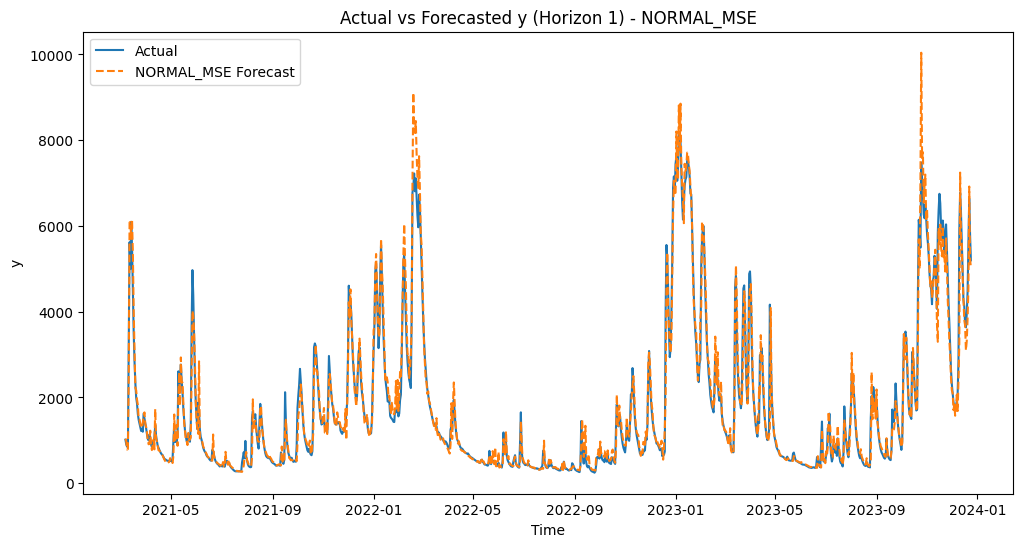

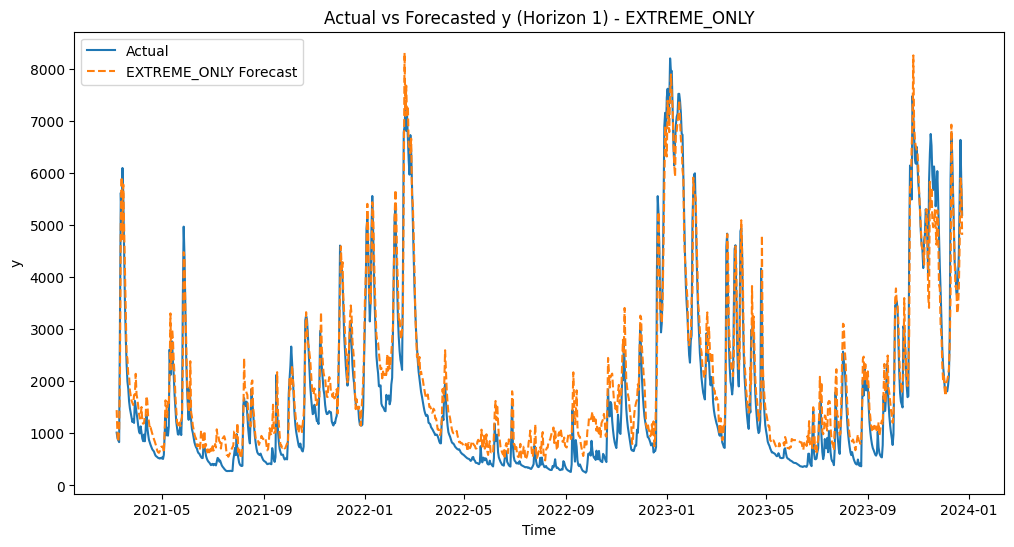

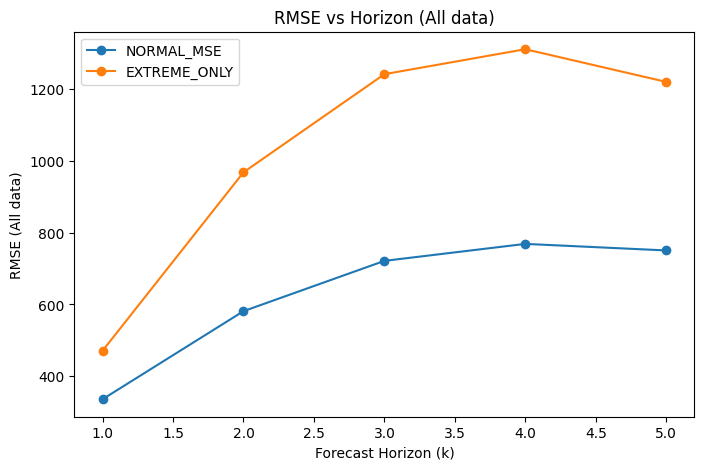

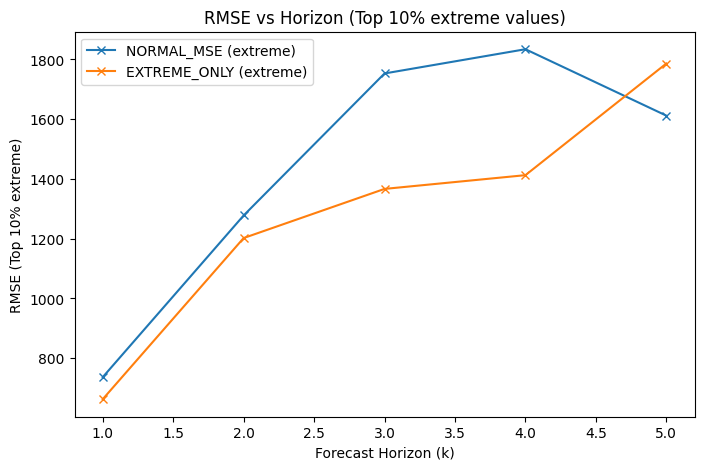

In [16]:
...

##########################################
# Training and Evaluation with Extreme Only Model
##########################################

window_size = 10
horizons = [1, 2, 3, 4, 5]

results = {}
models_to_train = ['normal_mse', 'extreme_only']

for model_type in models_to_train:
    print(f"\n===== Training {model_type.upper()} Model =====")

    rmse_all = {}
    rmse_extreme = {}
    forecasts = {}

    for k in horizons:
        print(f"Training model for Horizon {k}")

        X_hist, X_fcst, y, indices = create_offline_dataset_horizon(D_time_indexed, window_size, k)
        train_mask = indices < score_start
        test_mask = indices >= score_start

        X_hist_train, X_fcst_train, y_train = X_hist[train_mask], X_fcst[train_mask], y[train_mask]
        X_hist_test, X_fcst_test, y_test, indices_test = X_hist[test_mask], X_fcst[test_mask], y[test_mask], indices[test_mask]

        if model_type == 'extreme_only':
            threshold = np.percentile(y_train, 70)
            extreme_mask = y_train >= threshold
            X_hist_train = X_hist_train[extreme_mask]
            X_fcst_train = X_fcst_train[extreme_mask]
            y_train = y_train[extreme_mask]

        if len(y_test) == 0 or len(y_train) == 0:
            continue

        model = build_offline_model(window_size, loss_fn=mse_loss)

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ]

        model.fit([X_hist_train, X_fcst_train], y_train,
                  validation_split=0.2,
                  epochs=100,
                  batch_size=32,
                  verbose=0,
                  callbacks=callbacks)

        y_pred = model.predict([X_hist_test, X_fcst_test], verbose=0).flatten()

        forecasts[k] = (indices_test, y_test, y_pred)
        rmse_all[k] = calculate_rmse(y_test, y_pred)
        rmse_extreme[k] = calculate_rmse_extreme(y_test, y_pred)

        print(f"Horizon {k}: RMSE (All) = {rmse_all[k]:.4f}, RMSE (Extreme) = {rmse_extreme[k]:.4f}")

    results[model_type] = {'forecasts': forecasts, 'rmse_all': rmse_all, 'rmse_extreme': rmse_extreme}

##########################################
# Plotting Comparison
##########################################

for model_type in models_to_train:
    idx, y_true, y_pred = results[model_type]['forecasts'][1]
    plt.figure(figsize=(12,6))
    plt.plot(idx, y_true, label='Actual')
    plt.plot(idx, y_pred, label=f'{model_type.upper()} Forecast', linestyle='--')
    plt.title(f'Actual vs Forecasted y (Horizon 1) - {model_type.upper()}')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()

plt.figure(figsize=(8,5))
for model_type in models_to_train:
    rmse_values = [results[model_type]['rmse_all'][k] for k in horizons]
    plt.plot(horizons, rmse_values, marker='o', label=f'{model_type.upper()}')
plt.xlabel('Forecast Horizon (k)')
plt.ylabel('RMSE (All data)')
plt.title('RMSE vs Horizon (All data)')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
for model_type in models_to_train:
    rmse_values_extreme = [results[model_type]['rmse_extreme'][k] for k in horizons]
    plt.plot(horizons, rmse_values_extreme, marker='x', label=f'{model_type.upper()} (extreme)')
plt.xlabel('Forecast Horizon (k)')
plt.ylabel('RMSE (Top 10% extreme)')
plt.title('RMSE vs Horizon (Top 10% extreme values)')
plt.legend()
plt.show()


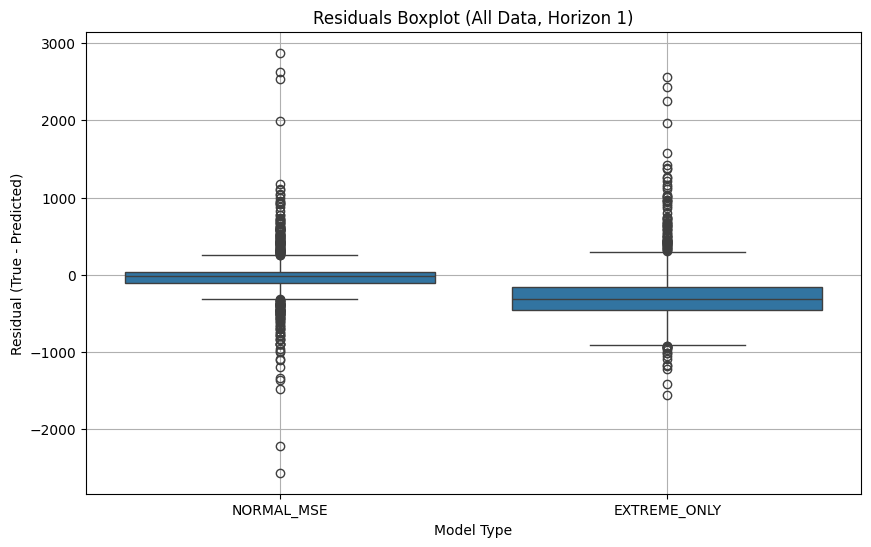

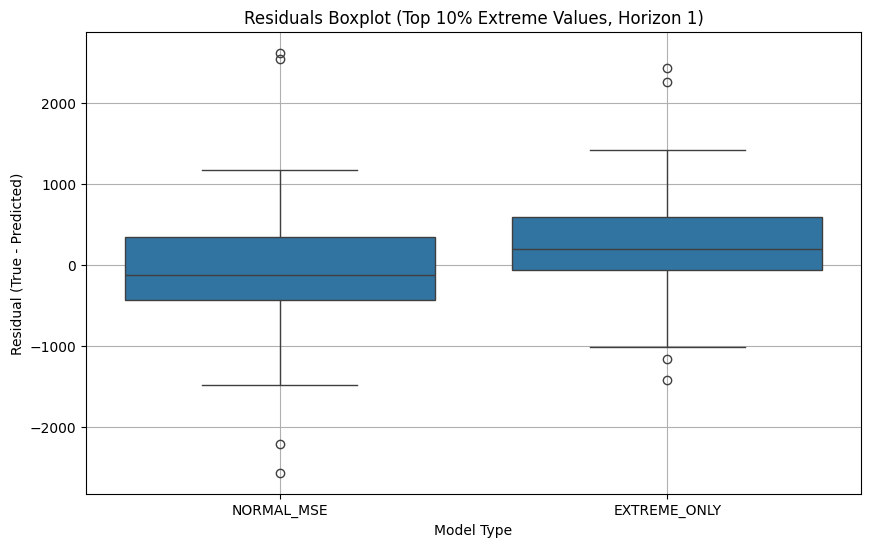

In [19]:
...

##########################################
# Residuals Boxplot (All Data)
##########################################

import seaborn as sns

residuals = []
labels = []

for model_type in models_to_train:
    _, y_true, y_pred = results[model_type]['forecasts'][1]
    residual = y_true - y_pred
    residuals.append(residual)
    labels.extend([model_type.upper()] * len(residual))

residuals = np.concatenate(residuals)

plt.figure(figsize=(10,6))
sns.boxplot(x=labels, y=residuals)
plt.title('Residuals Boxplot (All Data, Horizon 1)')
plt.ylabel('Residual (True - Predicted)')
plt.xlabel('Model Type')
plt.grid(True)
plt.show()

##########################################
# Residuals Boxplot (Extreme Data Only)
##########################################

residuals_extreme = []
labels_extreme = []

for model_type in models_to_train:
    _, y_true, y_pred = results[model_type]['forecasts'][1]
    threshold = np.percentile(y_true, 90)
    extreme_mask = y_true >= threshold
    residual_extreme = (y_true - y_pred)[extreme_mask]
    residuals_extreme.append(residual_extreme)
    labels_extreme.extend([model_type.upper()] * len(residual_extreme))

residuals_extreme = np.concatenate(residuals_extreme)

plt.figure(figsize=(10,6))
sns.boxplot(x=labels_extreme, y=residuals_extreme)
plt.title('Residuals Boxplot (Top 10% Extreme Values, Horizon 1)')
plt.ylabel('Residual (True - Predicted)')
plt.xlabel('Model Type')
plt.grid(True)
plt.show()

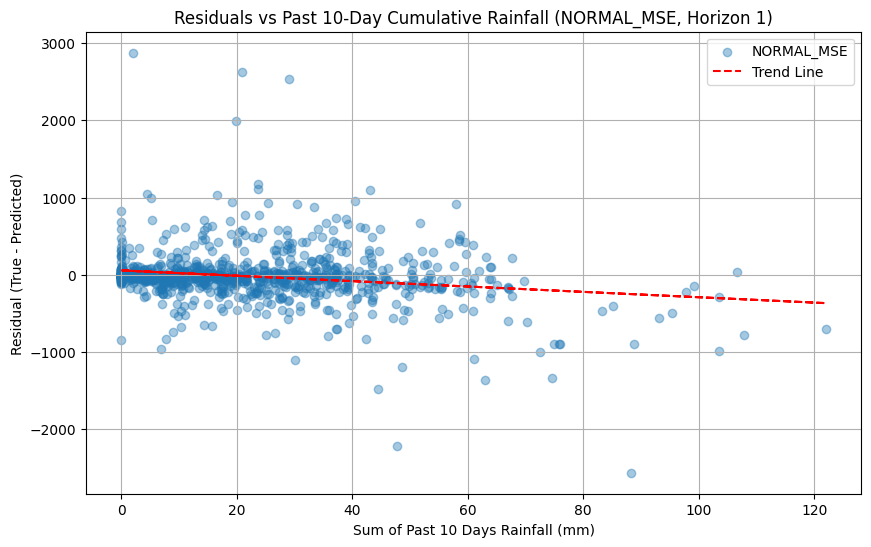

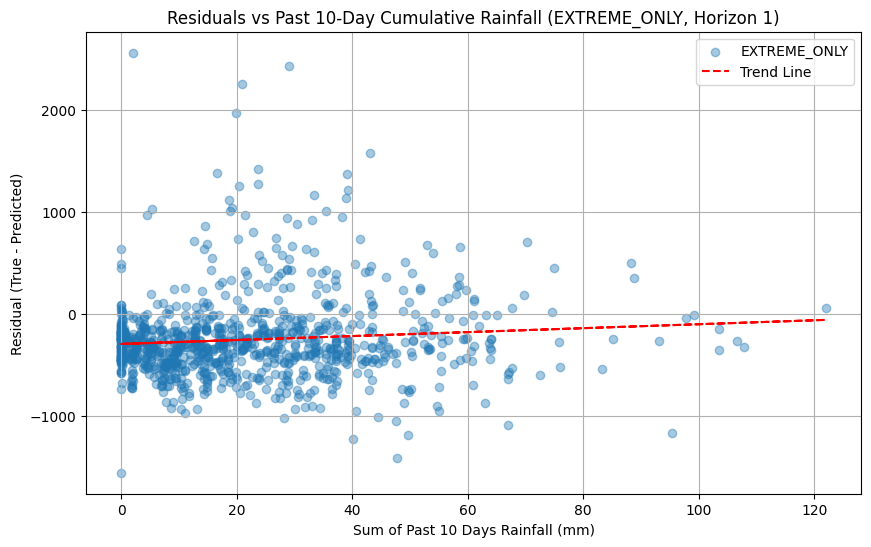

In [22]:
##########################################
# Residuals vs Past 10-Day Cumulative Rainfall (All Data)
##########################################

from scipy.stats import linregress

for model_type in models_to_train:
    idx, y_true, y_pred = results[model_type]['forecasts'][1]
    X_hist, X_fcst, y, indices = create_offline_dataset_horizon(D_time_indexed, window_size, 1)
    test_mask = indices >= score_start

    X_hist_test = X_hist[test_mask]
    cum_rain_last_10_days = np.sum(X_hist_test[:, :, 2], axis=1)  # Sum of past 10 days precipitation

    residual = y_true - y_pred

    slope, intercept, _, _, _ = linregress(cum_rain_last_10_days, residual)
    line = slope * cum_rain_last_10_days + intercept

    plt.figure(figsize=(10,6))
    plt.scatter(cum_rain_last_10_days, residual, alpha=0.4, label=f'{model_type.upper()}')
    plt.plot(cum_rain_last_10_days, line, color='red', linestyle='--', label='Trend Line')
    plt.title(f'Residuals vs Past 10-Day Cumulative Rainfall ({model_type.upper()}, Horizon 1)')
    plt.xlabel('Sum of Past 10 Days Rainfall (mm)')
    plt.ylabel('Residual (True - Predicted)')
    plt.grid(True)
    plt.legend()
    plt.show()
